Epoch 100: Loss = 0.0351
Epoch 200: Loss = 0.0207
Epoch 300: Loss = 0.0130
Epoch 400: Loss = 0.0089
Epoch 500: Loss = 0.0068
Epoch 600: Loss = 0.0056

Training complete
Final weights: [ 0.3405184   0.15667407 -0.06342798  0.37820813]
Final bias: -0.013402871787548065
Model saved to thai_sentiment_model.npz


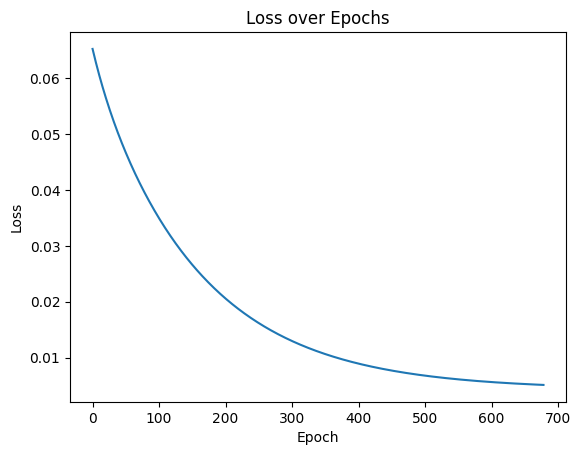


Testing the model with 5 samples:
Word: กล้อง, Features: [ 0.05 -0.09  0.   -0.04], True Value = 0.0300, Predicted Value = -0.0256
Word: หยุดนิ่ง, Features: [ 0.    0.18 -0.12  0.23], True Value = 0.1000, Predicted Value = 0.1094
Word: กำลัง, Features: [ 0.01  0.14 -0.1   0.15], True Value = 0.0600, Predicted Value = 0.0750
Word: การคาดคะเน, Features: [-0.04  0.5  -0.03  0.08], True Value = 0.1700, Predicted Value = 0.0835
Word: พิษสง, Features: [ 0.    0.14 -0.18  0.15], True Value = 0.0400, Predicted Value = 0.0767


In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# โหลดข้อมูลจากไฟล์ SenticNet2_Thai.txt
# สมมติว่าไฟล์มีข้อมูลในรูปแบบ "Index,Word,Pleasantness,Attention,Sensitivity,Aptitude,Polarity Value"
data = []
words = []
with open('SenticNet2_Thai.txt', 'r', encoding='utf-8') as file:
    next(file)  # ข้ามบรรทัดแรกที่เป็นหัวข้อ
    for line in file:
        parts = line.strip().split(',')  # แยกข้อมูลด้วยคอมมา
        words.append(parts[1])  # เก็บคำไว้สำหรับอ้างอิง
        data.append([float(parts[2]), float(parts[3]), float(parts[4]), float(parts[5]), float(parts[6])])  # เก็บค่าที่สนใจ

# แปลงข้อมูลให้อยู่ในรูปแบบ numpy array เพื่อความสะดวกในการประมวลผล
data = np.array(data, dtype=np.float32)

# แยกฟีเจอร์ (x) และค่าที่ต้องการพยากรณ์ (y)
x = data[:, :-1]  # เลือก 4 Sentic values
y = data[:, -1]   # เลือกค่า Polarity Value

# สร้างตัวแปร TensorFlow สำหรับเก็บข้อมูลฟีเจอร์และค่าที่ต้องการพยากรณ์
X = tf.Variable(x, dtype=tf.float32, name="X")
Y = tf.Variable(y, dtype=tf.float32, name="Y")

# สร้างตัวแปรน้ำหนัก (w) และ bias (b) เริ่มต้นค่าเป็นศูนย์
w = tf.Variable(np.zeros((4, 1), dtype=np.float32), name="weights")
b = tf.Variable(np.float32(0.0), name="bias")

# กำหนดโมเดล โดยใช้สมการ y = x * w + b
@tf.function
def forward(x):
    return tf.matmul(x, w) + b

# กำหนดฟังก์ชัน Loss ที่ใช้วัดความผิดพลาดของโมเดล
loss_fn = tf.keras.losses.MeanSquaredError()

# เลือก Optimizer เป็น Stochastic Gradient Descent (SGD) พร้อมกำหนดค่า learning rate
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

# กำหนดค่าพารามิเตอร์สำหรับการฝึกโมเดล
max_number_of_epochs = 1000  # จำนวนรอบการฝึกสูงสุด
loss_array = []  # เก็บค่าความผิดพลาดในแต่ละรอบ

# ตั้งค่าเริ่มต้นให้ w และ b เป็นศูนย์
w.assign(np.zeros((4, 1), dtype=np.float32))
b.assign(np.float32(0.0))

# ลูปสำหรับการฝึกโมเดล
for epoch in range(max_number_of_epochs):
    with tf.GradientTape() as tape:
        y_predicted = forward(X)  # คำนวณค่าที่โมเดลพยากรณ์ได้
        loss_value = loss_fn(Y, tf.squeeze(y_predicted))  # คำนวณค่าความผิดพลาด

    # คำนวณ Gradient และอัปเดตค่าพารามิเตอร์ w และ b
    gradients = tape.gradient(loss_value, [w, b])
    optimizer.apply_gradients(zip(gradients, [w, b]))

    # เก็บค่าความผิดพลาดในแต่ละรอบ
    loss_array.append(loss_value.numpy())

    # แสดงผลทุก ๆ 100 รอบ
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch + 1}: Loss = {loss_value.numpy():.4f}")

    # เช็คเงื่อนไข Early Stopping ถ้า Loss เปลี่ยนน้อยกว่าเกณฑ์ หยุดฝึก
    if epoch > 0 and abs(loss_array[-1] - loss_array[-2]) / loss_array[-2] < 0.001:
        break

# แสดงค่าพารามิเตอร์ w และ b หลังการฝึกเสร็จ
print("\nTraining complete")
print(f"Final weights: {w.numpy().flatten()}")
print(f"Final bias: {b.numpy()}")

# บันทึกโมเดลลงไฟล์
model_save_path = "thai_sentiment_model"
weights_and_bias = {"weights": w.numpy(), "bias": b.numpy()}
np.savez(model_save_path, **weights_and_bias)
print(f"Model saved to {model_save_path}.npz")

# พล็อตกราฟแสดงค่าความผิดพลาด (Loss) ในแต่ละรอบการฝึก
plt.plot(loss_array)
plt.xlabel("Epoch")  # แกน X คือจำนวนรอบ (Epoch)
plt.ylabel("Loss")  # แกน Y คือค่าความผิดพลาด (Loss)
plt.title("Loss over Epochs")  # ชื่อกราฟ
plt.show()

# ทดสอบโมเดลด้วยคำตัวอย่าง 5 ตัว
print("\nTesting the model with 5 samples:")
test_samples = x[:5]
test_words = words[:5]
true_values = y[:5]
predicted_values = forward(test_samples).numpy().flatten()

for i in range(5):
    print(f"Word: {test_words[i]}, Features: {test_samples[i]}, True Value = {true_values[i]:.4f}, Predicted Value = {predicted_values[i]:.4f}")
